## From shapefiles to a custom dataset in YOLOv8

The conversion from shapefiles to training data follows the same procedure as for the generation of training data for the Mask R-CNN model architecture: 

1. Select all of the shapefiles and all of the region of mapping (not the), and clip boulders to it (clip to patches).
2. Select already generated pickle files (contain information to tile rasters).
3. Read all boulder shapefiles and pickle files and concatenate them in one GeoDataframe/Dataframe (for each of them)
4. Specify main path to rasters.
5. Split in train-validation-test split based on selected percentages.
6. Tile rasters based on mapped patches.
7. Update absolute path to boulder mapping
8. Tile shapefiles from dataframe
9. Save pickle (in case you want to re-run it)
10. Generate YOLOv8 custom dataset for import during training

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import sys
import skimage
import pycocotools.mask as mask_util

from shptools_BOULDERING import shp, geometry as shp_geom, geomorph as shp_geomorph, annotations as shp_anno, metrics as shp_metrics
from rastertools_BOULDERING import raster, metadata as raster_metadata, crs as raster_crs
from pathlib import Path
from tqdm import tqdm

Steps 1 to 8 are already described at https://github.com/astroNils/MLtools/blob/main/resources/nb/PREPROCESSING_BOULDERING.ipynb. Just follow the same step, and you will end up with a pandas dataframe with all of the information you need! I am just directly loading the dataframe below. <br>

We here need to focus on converting the masks representing the outlines of boulders into the YOLOv8 format. You can learn more about the format here: https://docs.ultralytics.com/datasets/segment/#supported-dataset-formats.

In [7]:
json_file = Path("D:/BOULDERING/data/preprocessing_Jan2024/json/Jan2024-Mars-Moon-Earth-mask-0px-windows.json") # change to your local path
img_dir = Path("D:/BOULDERING/data/preprocessing_Jan2024") # change to your local path where tiled images have been saved. 

In [5]:
df = pd.read_json(json_file)

In [6]:
df.head(5)

,file_name,height,width,image_id,dataset,annotations
0,M1221383405_1718_image.png,500,500,0,train,"[{'bbox': [142.0, 498.0, 151.0, 500.0], 'bbox_..."
1,M121627645_01013_image.png,500,500,1,train,"[{'bbox': [57.0, 490.0, 61.0, 496.0], 'bbox_mo..."
2,M139694087LE_0792_image.png,500,500,2,train,"[{'bbox': [461.0, 335.0, 469.0, 342.0], 'bbox_..."
3,M121267110_01679_image.png,500,500,3,train,"[{'bbox': [282.0, 487.0, 288.0, 491.0], 'bbox_..."
4,M121267110_01425_image.png,500,500,4,validation,"[{'bbox': [383.0, 387.0, 394.0, 400.0], 'bbox_..."


We have the filenames, heights, and widths (you might have 512), image IDs, whether the tile is part of the train, validation, or test datasets, and then some information about the bounding boxes and masks of the outlines. So far, it is the same as for Mask R-CNN. <br>

If you look into the annotations, you can see that the segmentation (i.e., the masks) are saved as the RLE format (https://en.wikipedia.org/wiki/Run-length_encoding), which is the segmentation format used by Mask R-CNN. This is the part we want to change. Let's have a close look at how a single RLE string can be converted as YOLO segmentation text file.

In [29]:
row = df.iloc[0]
anno = row["annotations"]
anno[10]

{'bbox': [64.0, 485.0, 70.0, 491.0],
 'bbox_mode': 0,
 'category_id': 0,
 'segmentation': {'size': [500, 500], 'counts': 'Vgo03a?2M1001O1Mc_a6'}}

In [30]:
anno[10]["segmentation"]

{'size': [500, 500], 'counts': 'Vgo03a?2M1001O1Mc_a6'}

The following command can be used to convert a binary mask into a polygon (x and y coordinates). 

In [32]:
def binary_mask_to_polygon(binary_mask):
    """Converts a binary mask to polygon representation
    Args:
        binary_mask: a 2D binary numpy array where '1's represent the object
        tolerance: Maximum distance from original points of polygon to approximated
            polygonal chain. If tolerance is 0, the original coordinate array is returned.
    """
    polygon = []
    # pad mask to close contours of shapes which start and end at an edge
    padded_binary_mask = np.pad(binary_mask, pad_width=1, mode='constant', constant_values=0)
    contours = skimage.measure.find_contours(padded_binary_mask, 0.5)

    # yolo can produce a mask where pixels are not interconnected
    # in this case the following line does not work
    contours = np.subtract(contours, 1)
    contour = np.flip(contours[0], axis=1) # should be interconnected
    return contour

In [25]:
rle = anno[10]["segmentation"]
m = skimage.morphology.remove_small_holes(mask_util.decode(rle).astype("bool")) # mask_util decode rle into binary mask

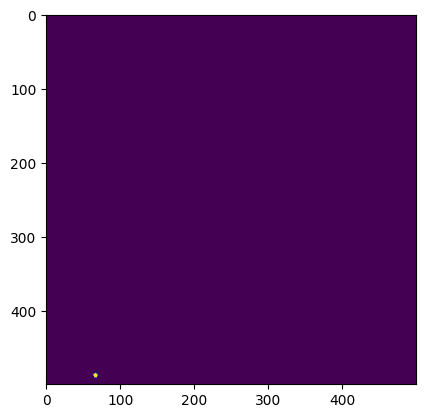

In [26]:
plt.imshow(m) # you can see a boulder in the lower left corner.

## Generation of the YOLOv8 segmentation text file for one boulder outline

#### binary mask to polygon

In [34]:
contour = binary_mask_to_polygon(m)
contour

array([[ 68. , 490.5],
       [ 67. , 490.5],
       [ 66. , 490.5],
       [ 65. , 490.5],
       [ 64.5, 490. ],
       [ 64.5, 489. ],
       [ 64. , 488.5],
       [ 63.5, 488. ],
       [ 63.5, 487. ],
       [ 63.5, 486. ],
       [ 64. , 485.5],
       [ 65. , 485.5],
       [ 65.5, 485. ],
       [ 66. , 484.5],
       [ 67. , 484.5],
       [ 67.5, 485. ],
       [ 68. , 485.5],
       [ 68.5, 486. ],
       [ 69. , 486.5],
       [ 69.5, 487. ],
       [ 69.5, 488. ],
       [ 69. , 488.5],
       [ 68.5, 489. ],
       [ 68.5, 490. ],
       [ 68. , 490.5]])

The mask is now converted to set of x and y coordinates.

#### polygon to YOLOv8 string

In [36]:
c = np.array(contour).squeeze()
cc = np.stack([c[:,0], c[:,1]], axis=-1) 
arr = cc.flatten() / row.height
arr = list(arr.round(decimals = 3))
arr.insert(0, 0)
str_arr = [str(a) for a in arr]
line = " ".join(str_arr)  + "\n"
line

'0 0.136 0.981 0.134 0.981 0.132 0.981 0.13 0.981 0.129 0.98 0.129 0.978 0.128 0.977 0.127 0.976 0.127 0.974 0.127 0.972 0.128 0.971 0.13 0.971 0.131 0.97 0.132 0.969 0.134 0.969 0.135 0.97 0.136 0.971 0.137 0.972 0.138 0.973 0.139 0.974 0.139 0.976 0.138 0.977 0.137 0.978 0.137 0.98 0.136 0.981\n'

https://docs.ultralytics.com/datasets/segment/#supported-dataset-formats. <br>

The first number describes the object's nature. In our case, we only detect boulders, so we set 0 to all objects. NB! If you work with more than one class, this code needs to be modified! The remaining values depict the normalized x and y coordinates, so it's imåportant that the height and width in the data frame are correct! 

## Generation of the YOLOv8 segmentation text file for all boulder outlines

In [ ]:
npixels_threshold = 6 # minimum number of pixels to be considered as a valid boulder
image_size = 500 # change accordingly

for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    masks = []
    for r in row.annotations:
        rle = r["segmentation"]
        # to avoid holes within mask
        masks.append(skimage.morphology.remove_small_holes(mask_util.decode(rle))) # just in case there is a hole in there. 

    contours = []
    for m in masks:
        npixels = len(m[m == 1])
        # min, max area (max area is set to 75% of the size of the image)
        if np.logical_and(npixels > npixels_threshold, npixels < (0.75 * image_size) * (0.75 * image_size)):
            contours.append(binary_mask_to_polygon(m))
        
    txt_stem = row.file_name.replace("png", "txt")
    txt_filename = pre_processed_folder / row.dataset / "labels" / txt_stem
    with open(txt_filename.as_posix(), "a") as f:
        for contour in contours:
            c = np.array(contour).squeeze()
            cc = np.stack([c[:,0], c[:,1]], axis=-1) 
            arr = cc.flatten() / row.height
            arr = list(arr.round(decimals = 3))
            arr.insert(0, 0) # we only have one type of object to detect (boulder). If you work with more than one class, the code needs to be modified! 
            # see https://docs.ultralytics.com/datasets/segment/#supported-dataset-formats.
            str_arr = [str(a) for a in arr]
            line = " ".join(str_arr)  + "\n"
            f.writelines(line)

This code will generate a text file per image/tile (in the same folder as the shapefiles). 

## Generation YAML file describing where training/validation/test data is...
The last piece of the puzzle is to create a YAML file (as below) to tell where to look for the data (this will be one of the inputs in the training of the model).

```yaml
train: D:/BOULDERING/data/yolov8/datasets/boulder2024/train/images # change to your path
val: D:/BOULDERING/data/yolov8/datasets/boulder2024//validation/image # change to your path 
test: D:/BOULDERING/data/yolov8/datasets/boulder2024/test/imag # change to your path) 
nc: 1
# classes (only 1)
names:
  0: boulder
```

You only have to specify the path to the images. if labels are saved to `D:/BOULDERING/data/yolov8/datasets/boulder2024/train/labels`, `D:/BOULDERING/data/yolov8/datasets/boulder2024/validation/labels`, `D:/BOULDERING/data/yolov8/datasets/boulder2024/test/labels`, they will be automatically detected by YOLOv8. 